# Lezione 5

In [ ]:
from liblet import Tree, Grammar, ProductionGraph, Derivation, side_by_side, iter2table, animate_derivation

In [ ]:
# Costruzione del parse tree (vedi L04)

def parse_tree(G, leftmost_steps):
    d = Derivation(G).leftmost(leftmost_steps)
    root = [{'Symbol': d.G.S, 'nprod': None}]
    sentence = [root, ] 
    for prod, pos in d.steps():
        tree = sentence[pos]
        children = [[{'Symbol': X, 'nprod': None}] for X in d.G.P[prod].rhs]
        tree[0]['nprod'] = prod
        tree.extend(children)
        sentence = sentence[:pos] + children + sentence[pos + 1:]
    return root

In [ ]:
# Costruzione del production graph (funzine di utilità)

def production_graph(G, leftmost_steps):
    return ProductionGraph(Derivation(G).leftmost(leftmost_steps))

# Ambiguità


## È sempre rilevante? 

Pensiamo a grammatiche della forma `E -> E op E | n` dove `op` sia un operatore binario, definiamo una funzione ricorsiva che, dato un albero di parsing e il valore di `n`, valuti l'espressione aritmetica corrispondente.

In [ ]:
from operator import add, sub, mul

DT = {
    '+': add,
    '-': sub,
    '*': mul
}

def eval_tree(tree, n):
    root, *children = tree
    if root['Symbol'] == 'n': return n
    if root['Symbol'] == 'E' and len(children) == 3:
        left, op, right = children
        return DT[op[0]['Symbol']](eval_tree(left, n), eval_tree(right, n))
    else: return eval_tree(children[0], n)

### Il caso "spurio"

In [ ]:
G_as = Grammar.from_string('E -> E + E | n')

# due derivazioni di n + n + n

side_by_side(
    production_graph(G_as, [0, 1, 0, 1, 1]),
    production_graph(G_as, [0, 0, 1, 1, 1]),
)

In [ ]:
# 1 + 1 + 1, comunque parsato, vale 3

(
    eval_tree(parse_tree(G_as, [0, 1, 0, 1, 1]), 1), 
    eval_tree(parse_tree(G_as, [0, 0, 1, 1, 1]), 1)
)

(3, 3)

### I casi "essenziali"

Iniziamo dall'associatività/commutatività

In [ ]:
G_ae = Grammar.from_string('E -> E - E | n')

# due derivazioni di n - n - n

side_by_side(
    production_graph(G_ae, [0, 1, 0, 1, 1]),
    production_graph(G_ae, [0, 0, 1, 1, 1]),
)

In [ ]:
# 1 - (1 - 1) e (1 - 1) - 1 hanno valori diversi!

(
    eval_tree(parse_tree(G_ae, [0, 1, 0, 1, 1]), 1), 
    eval_tree(parse_tree(G_ae, [0, 0, 1, 1, 1]), 1)
)

(1, -1)

Consideriamo la *precedenza* 

In [ ]:
G_perr = Grammar.from_string("""
E -> E + E | E * E | n
""")

# n + n * n

side_by_side(
    production_graph(G_perr, [1, 0, 2, 2, 2]),
    production_graph(G_perr, [0, 2, 1, 2, 2])
)

In [ ]:
# ((2 + 2) * 2) e 2 + (2 * 2) hanno valori diversi!

(
    eval_tree(parse_tree(G_perr, [1, 0, 2, 2, 2]), 2),
    eval_tree(parse_tree(G_perr, [0, 2, 1, 2, 2]), 2)
)

(8, 6)

Per finire, un esempio non collegato alle *espressioni*, ma al *dangling else*

In [ ]:
G_iferr = Grammar.from_string("""
S -> if C then S | if C then S else S | stm
C -> cond
""")

In [ ]:
# if cond the if cont then stm else stm

side_by_side(
    production_graph(G_iferr, [0, 3, 1, 3, 2, 2]),
    production_graph(G_iferr, [1, 3, 0, 3, 2, 2])
)

## Possibili soluzioni

Un simbolo in più, ricorsione *sinistra* o *destra* e relazione con l'*associatività*.

In [ ]:
G_la = Grammar.from_string("""
E -> E + E' | E'
E' -> n 
""")
G_la

Grammar(N={E, E'}, T={+, n}, P=(E -> E + E', E -> E', E' -> n), S=E)

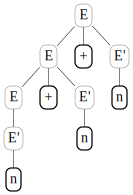

In [ ]:
production_graph(G_la, [0, 0, 1, 2, 2, 2])

In [ ]:
G_ra = Grammar.from_string("""
E -> E' ^ E | E'
E' -> n 
""")
G_ra

Grammar(N={E, E'}, T={^, n}, P=(E -> E' ^ E, E -> E', E' -> n), S=E)

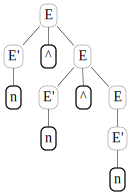

In [ ]:
production_graph(G_ra, [0, 2, 0, 2, 1, 2])

Per la *precedenza* occorre aggiungere più di un simbolo…

In [ ]:
G_p = Grammar.from_string("""
E -> E + P | P
P -> P * F | F
F -> n
""")

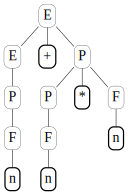

In [ ]:
production_graph(G_p, [0, 1, 3, 4, 2, 3, 4, 4])

Il caso del *dangling else*

In [ ]:
G_if = Grammar.from_string("""
S -> M | U
M -> if C then M else M | stm
U -> if C then M else U | if C then S
C -> cond
""")

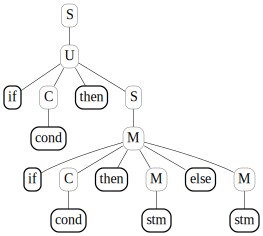

In [ ]:
production_graph(G_if, [1, 5, 6, 0, 2, 6, 3, 3])

# Parsing

## Top down

In [ ]:
w = 'aabbcc'

G = Grammar.from_string("""
S -> a S Q | a b c
b Q c -> b b c c  
c Q -> Q c
""", False)

In [ ]:
animate_derivation(Derivation(G).step([
    (0, 0), (1, 1), (3, 3), (2, 2)
]), height = '350px')

interactive(children=(IntSlider(value=0, description='n', max=4), Output(layout=Layout(height='350px'))), _dom…

## Bottom up

Nel caso *bottom up* si può procedere con una grammatica ottenuta rovesciando le produzioni (e aggiungendo una produzione `Inizio`$\to \omega$ dove `Inizio` è il nuovo simbolo di partenza (e volendo una produzione $S\to $`Fine` dove `Fine` è un simbolo usato per indicare la fine della derivazione).

In [ ]:
GR = Grammar.from_string("""
Inizio -> a a b b c c
a S Q -> S
a b c -> S 
b b c c -> b Q c
Q c -> c Q
S -> Fine
""", False)

In [ ]:
animate_derivation(Derivation(GR).step([
    (0, 0), (3, 2), (4, 3), (2, 1), (1, 0), (5, 0)
]), height = '500px')

interactive(children=(IntSlider(value=0, description='n', max=6), Output(layout=Layout(height='500px'))), _dom…